## DATA: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

### About Dataset
#### Context

  "Predict behavior to retain customers. Analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

#### Content
  Each row represents a customer, each column contains customer's attributes described in the column Metadata.


**The data set includes information about:**

- Customers who left within the last month -- the column is called Churn
- Services that each customer has signed up for -- phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information -- how long they've been customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers -- gender, age range, and if they have partners and dependents


In [ ]:
!pip install optuna lime shap --quite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_column', 300)
from sklearn.preprocessing import LabelEncoder # labelencoder is fine for tree base model
from imblearn.over_sampling import SMOTE # for solving imbalance in the data
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import optuna
from sklearn.model_selection import GridSearchCV
import pickle

## Step 1: Data Loading & Initial Exploration

In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
df.shape

(7043, 21)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
# dropping customerID columns as this is not required for modelling

df = df.drop('customerID', axis=1)

In [9]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [10]:
# Printing the unique values in all the columns

numerical_features_list = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("="*50)

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [11]:
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [12]:
df[df['TotalCharges'] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [13]:
df['TotalCharges'] = df['TotalCharges'].replace({" ": "0.0"})
df['TotalCharges'] = df['TotalCharges'].astype(float)

We noticed that there's imbalance in the dateset so because of this we can not directly train a model, so we need to perform `upper sampling` or `down sampling`

In [14]:
# checking the class distribution of target column

print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**Insights:**
1. Customer ID removed as it is not required for modelling
2. No missing values in the datasets
3. Missing values in the TotalCharges column were replaced with 0
4. class imbalance identified in the target


## Step 2: Exploratory data Analysis (EDA)

In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [16]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [17]:
df.describe(include=[np.number])

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### Numerical Feature - Analysis

Understand the distribution of the numerical features

In [42]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(6, 4))
  sns.histplot(df[column_name], kde=True, bins=30, color='skyblue')

  # Calculate the mean and medain values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color='red', linestyle='dashed', label=f'Mean: {col_mean:.2f}')
  plt.axvline(col_median, color='green', linestyle='dotted', label=f'Median: {col_median:.2f}')

  # Set title and labels
  plt.title(f"Distribution of {column_name}", fontsize=14)
  plt.legend()

  plt.show()

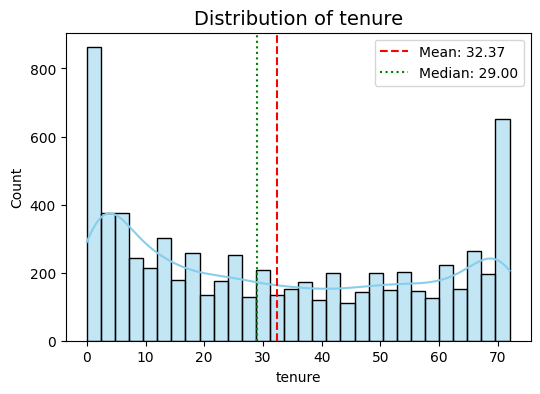

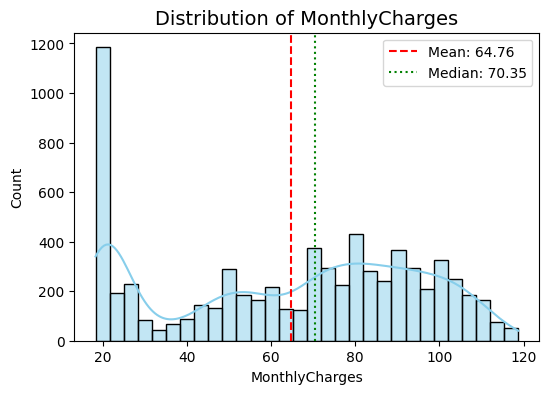

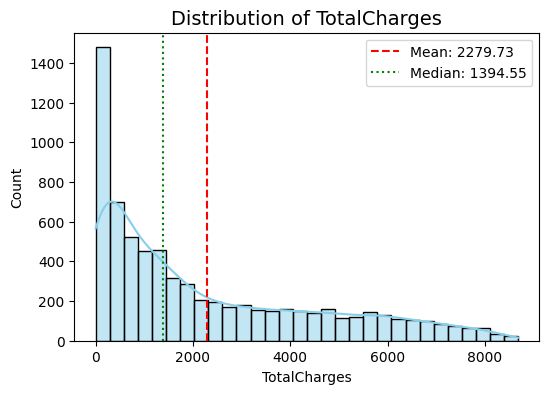

In [43]:
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
  plot_histogram(df, col)

**Box Plot for numerical features**

In [20]:
def plot_boxplot(df, column_list):
  num_plot = len(column_list)
  fig, axes = plt.subplots(1, num_plot, figsize=(15, 6))
  for i, col in enumerate(column_list):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel(col)

  plt.tight_layout()
  plt.show()

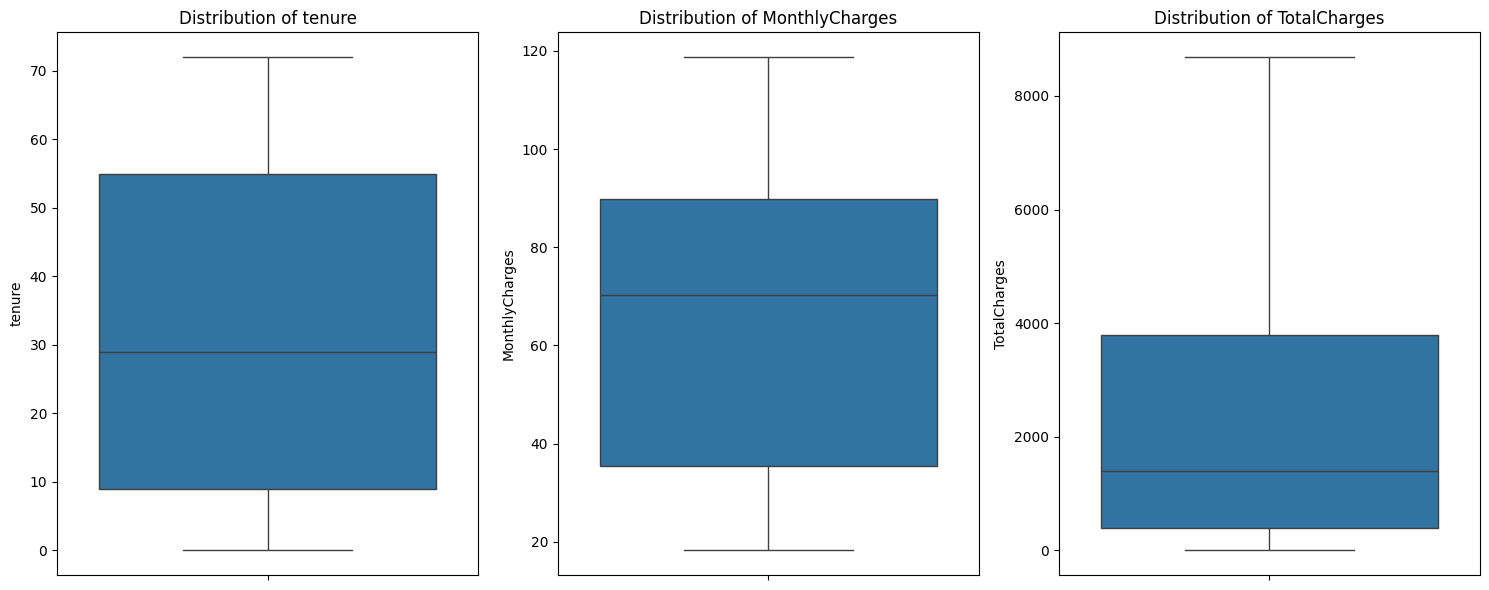

In [21]:
plot_boxplot(df, ['tenure', 'MonthlyCharges', 'TotalCharges'])

### Correlation Heatmap for numerical columns

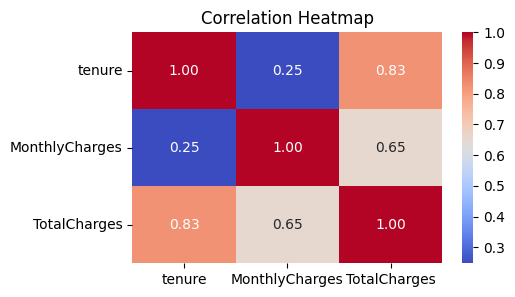

In [22]:
# correlation matrix - heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Categorical feature - Analysis

Countplot for categorical columns

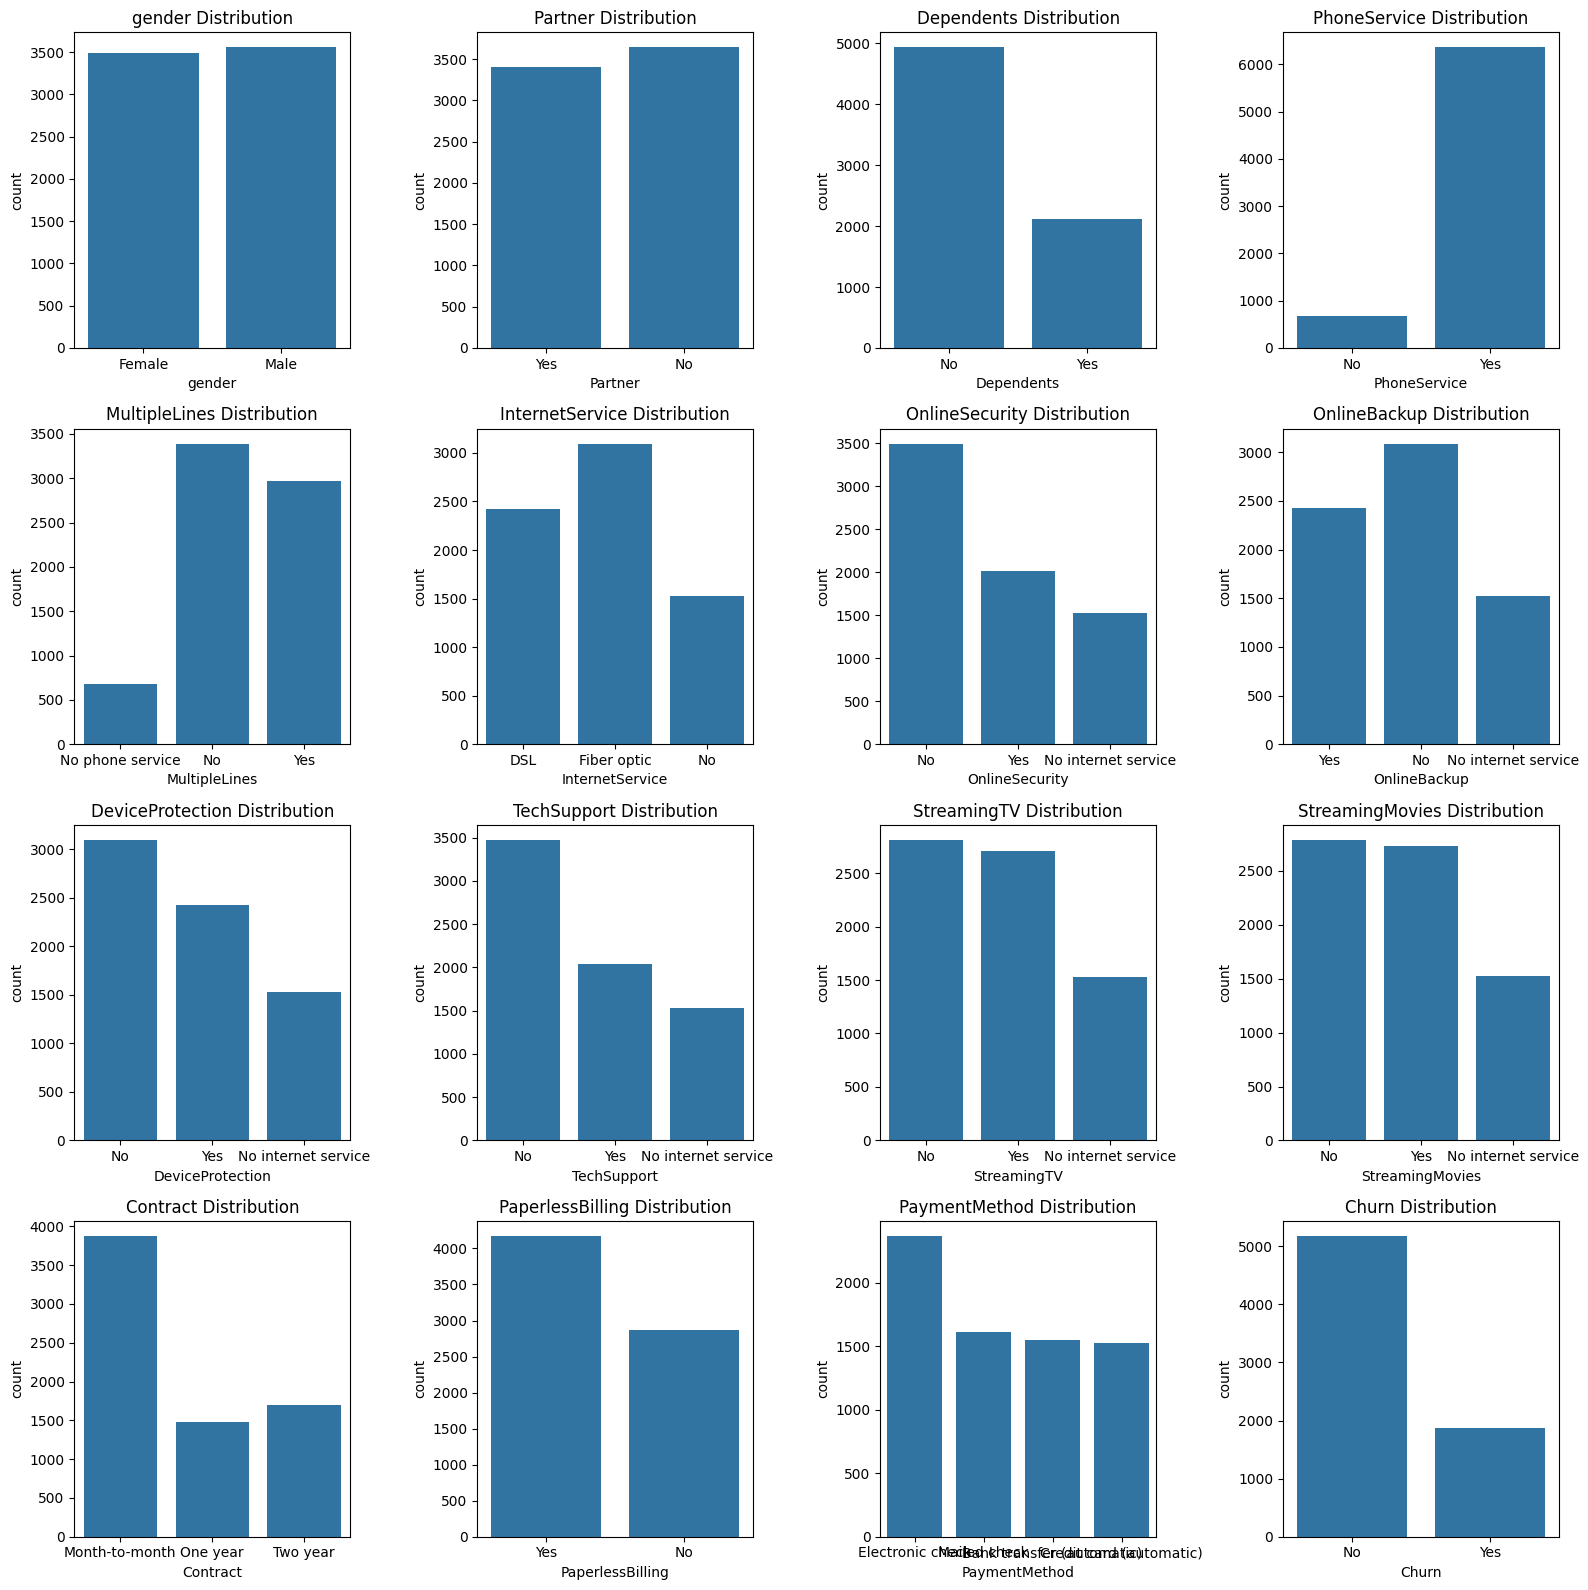

In [23]:
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

object_cols = categorical_features

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(object_cols):

    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} Distribution")

plt.tight_layout()
plt.show()

# Feature Engineering

In [24]:
def feature_engineering_train(df1):
  """Feaure engineering for training."""
  df = df1.copy()

  # Define categorical types
  contract_categories = df['Contract'].unique()
  payment_categories = df['PaymentMethod'].unique()

  contract_dtype = pd.CategoricalDtype(categories=contract_categories, ordered=False)
  payment_dtype = pd.CategoricalDtype(categories=payment_categories, ordered=False)

  with open('categories.pkl', 'wb') as f:
    pickle.dump((contract_categories, payment_categories), f)

  # Convert to categorical type
  df['Contract'] = df['Contract'].astype(contract_dtype)
  df['PaymentMethod'] = df['PaymentMethod'].astype(payment_dtype)

  # One-hot encode
  df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod'], drop_first=True)
  dummy_cols = [col for col in df.columns if col.startswith('Contract_') or col.startswith('PaymentMethod_')]
  df[dummy_cols] = df[dummy_cols].astype(int)

  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
  df['TotalCharges'] = df['TotalCharges'].fillna(0)
  df['tenure'] = df['tenure'].fillna(0)
  epsilon = 1e-5
  df['AvgCharge'] = df['TotalCharges'] / (df['tenure'] + epsilon)

  return df


def feature_engineering_predict(df, contract_categories, payment_categories):
  """Feature engineerinf for prediction."""

  df = df.copy()

  contract_dtype = pd.CategoricalDtype(categories=contract_categories, ordered=False)
  payment_dtype = pd.CategoricalDtype(categories=payment_categories, ordered=False)

  df['Contract'] = df['Contract'].astype(contract_dtype)
  df['PaymentMethod'] = df['PaymentMethod'].astype(payment_dtype)

  df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod'], drop_first=True)
  dummy_cols = [col for col in df.columns if col.startswith('Contract_') or col.startswith('PaymentMethod_')]
  df[dummy_cols] = df[dummy_cols].astype(int)

  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
  df['TotalCharges'] = df['TotalCharges'].fillna(0)
  df['tenure'] = df['tenure'].fillna(0)
  epsilon = 1e-5
  df['AvgCharge'] = df['TotalCharges'] / (df['tenure'] + epsilon)

  return df


df1 = feature_engineering_train(df)

## Step 3: Data Preprocessing

In [25]:
# encode the target column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['Churn'] = le.fit_transform(df1['Churn'])


# Label encoding of categorical features

object_columns = df1.select_dtypes(include=['object'])

# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df1[column] = label_encoder.fit_transform(df1[column])
  encoders[column] = label_encoder

# save the encoders to a pickle file
with open("encoders.pkl", 'wb') as f:
  pickle.dump(encoders, f)

# Step 4: Split the Data into Features and Target

Now that we've engineered some new features, let's split the data into predictors{X) and the target variable(y). Then we'll create training and test sets.

In [26]:
# Splitting the feature and target
X = df1.drop(columns=['Churn'], axis=1)
y = df1['Churn']

In [27]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5 Build a Baseline Model



In [28]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression


baseline_model = LogisticRegression(max_iter=5000)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print('='*50)
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))
print('='*50)
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('='*50)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8197303051809794
Confusion Matrix: [[932 104]
 [150 223]]
ROC AUC: 0.8625345471860216
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



##### Key Observations and Interpretaion:

These matrics suggest the feature engineering is on the right track

- **Class Imbalance:**
  - There's a noticeable class imbalance (1036 vs. 373), with significantly more samples in class 0. This is reflected in the higher precision and recall for class 0.
- **Model Performance:**
  - The model performs better in predicting class 0 than class 1. This is evident from the higher precision, recall, and F1-score for class 0.
  - The model has a good overall ability to distiguish between the two classes, as shown by the high ROC AUC score.
- **Precision vs. Recall Trade-off:**
  - For class 1, the precision (0.68) is higher than the recall(0.60). This means that when the model predicts class 1, it's relatively accurate, but it misses a significant portion of the actual class 1 samples.

## Synthetic Minority Oversampling Technique (SMOTE)

In [29]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 6: Train Model /Evaluation

# Hyperparameter Tuning Logistic Regression with Optuna

In [ ]:
# **logistic Regression**
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold


def objective(trial):
  """Objective function for Optuna."""

  # Define the search space
  C = trial.suggest_float("C", 1e-4, 1e4, log=True)
  solver = trial.suggest_categorical('solver', ['saga'])
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
  class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
  l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

  # Create a pipeline
  pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('logistic', LogisticRegression(C=C, solver=solver, penalty=penalty,
                                      class_weight=class_weight, random_state=42,
                                      max_iter=1000, l1_ratio=l1_ratio))
  ])

  # Cross-validation
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  scores = cross_val_score(pipe, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc')
  return scores.mean()

# Create a study and optimize
study = optuna.create_study(direction='maximize') # Maximize ROC AUC
study.optimize(objective, n_trials=100) # number of hyperparameter combinations to try.

# Print the best parameters and score
print('Best trial:', study.best_trial.params)
print('Best ROC AUC:', study.best_value)

# Train the final model with the best parameters
best_params = study.best_trial.params
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=42, max_iter = 1000, **best_params))
])
pipe.fit(X_train_smote, y_train_smote)

# make predictions.
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# RandomForestClassifier

# Hyperparameter tuning RandomForest with Optuna

Hyperparamter tuning can help improve model performance by finding the best combination of paramters. Let's use GridSearchCV on our RandomForest model.

In [ ]:

# from sklearn.pipleline import Pipeline
# from sklearn.preprocesing import StandardScaler

def objective(trial):
  """Objective function for optuna"""

  # Define the search space
  n_estimators = trial.suggest_int('n_estimators', 50, 500)
  max_depth = trial.suggest_int('max_depth', 3, 10)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
  class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

  # Create a pipeline
  rf_pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('randomforest', RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_leaf,
                                              min_samples_leaf=min_samples_leaf,
                                              class_weight=class_weight,
                                              max_features=max_features))
  ])

  # Cross validation
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  scores = cross_val_score(rf_pipe, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc')
  return scores.mean()


# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameter and score
print('Best trial:', study.best_trial.params)
print('Best ROC AUC:', study.best_value)


In [33]:
# Retrieve the best model
best_rf_params = study.best_trial.params

# Train model with the best params
best_rf = RandomForestClassifier(random_state=42, **best_rf_params)
best_rf.fit(X_train_smote, y_train_smote)

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]


print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Accuracy: 0.7828246983676366
ROC AUC: 0.8485112362458207
Confusion Matrix:
 [[835 201]
 [105 268]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1036
           1       0.57      0.72      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409



**Model Performance:**
  - Accuracy: 78.5%
  - ROC AUC: 0.848
  - Confusion Matrix:
    - True Positives (TP - No Churn Predictd Correctly): 838
    - False Positives (FP - Churn Predicted Incorrectly): 198
    - False Nagatives (FN - No Churn Prediction Incorrectly): 105
    - True Negatives (TN - Churn Predicted Correctly): 268
  - Precision (Churn): 58%
  - Recall (Churn): 72%


# Visualize Result of Model


In [197]:
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap="Blues"):
  """Plots a confusion matrix."""
  cm = confusion_matrix(y_test, y_pred_best)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
  plt.title(title)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.savefig('confusion_matric.png')
  plt.show()

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
  """Plots an ROC curve."""
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
  plt.plot([0, 1], [0, 1], color ='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.savefig('roc_curve.png')
  plt.show()

def plot_class_distribution(y, title='Class Distribution'):
  """Plots the class distribution."""
  plt.figure(figsize=(6, 4))
  sns.countplot(x=y)
  plt.title(title)
  plt.savefig('class_distribution.png')
  plt.show()

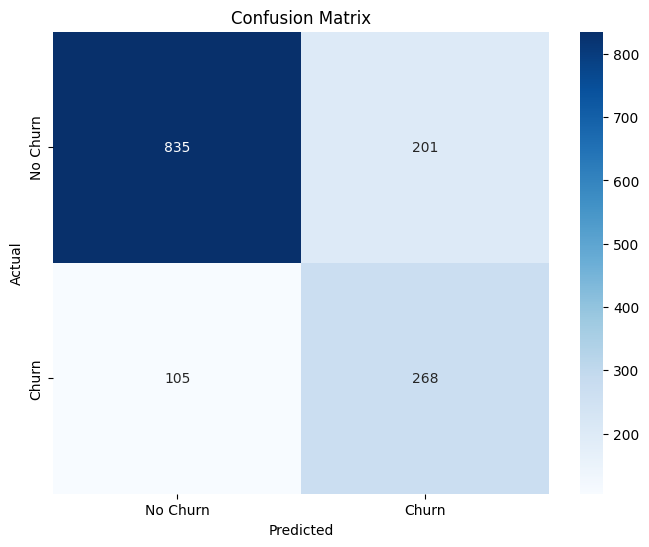

In [198]:
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_best, classes=["No Churn", "Churn"])


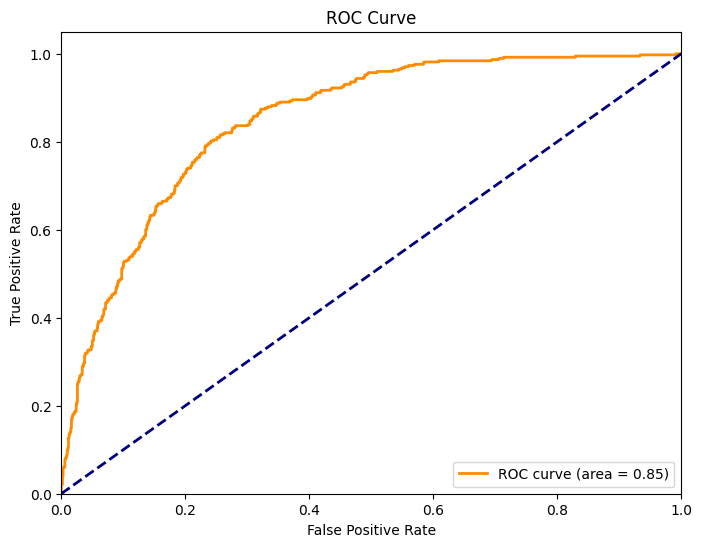

In [199]:
plot_roc_curve(y_true=y_test, y_pred_proba=y_proba_best)


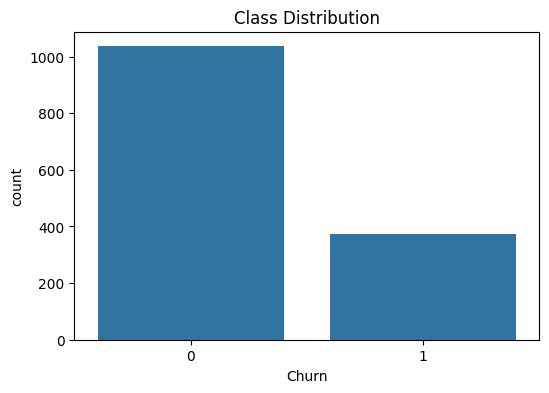

In [200]:
plot_class_distribution(y_test)


# Rebuild and fit the best pipeline on the full training data:

In [85]:
best_params_01 = study.best_trial.params
best_rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestClassifier(
        n_estimators=best_params_01['n_estimators'],
        max_depth=best_params_01['max_depth'],
        min_samples_split=best_params_01['min_samples_split'],
        min_samples_leaf=best_params_01['min_samples_leaf'],
        class_weight=best_params_01['class_weight'],
        max_features=best_params_01['max_features']
    ))
])

# Fit the pipeline on the training set
best_rf_pipe.fit(X_train_smote, y_train_smote)

# save the pipeline to disk
with open('best_rf_pipe.pkl', 'wb') as f:
  pickle.dump(best_rf_pipe, f)

# load the pipeline
with open('best_rf_pipe.pkl', 'rb') as f:
  best_rf_pipe = pickle.load(f)

# Explainability (SHAP/LIME)

Explaining why the model is making its prediction

1. SHAP (SHapley Additive exPlanations)
  - They provide a global and local explanation of model decisions:
    - **Global:** Helps understand overall feature importance across all predictions.
    - **Local:** Explans why a model made a specific prediction for an individual instance.

2. LIME (Locl Interpretable Model-agnostic Explanations)
  - LIME explains individual predictions by creating a simpler interpretable model (like a linear model) around a specific instance.
  - It perturbs the input data slightly and observes how predictions change, helping approximate the decision boundary of complex models.

## Explain Prediction Using SHAP

SHAP will help us understand which features are most important globally and for individual predictions.

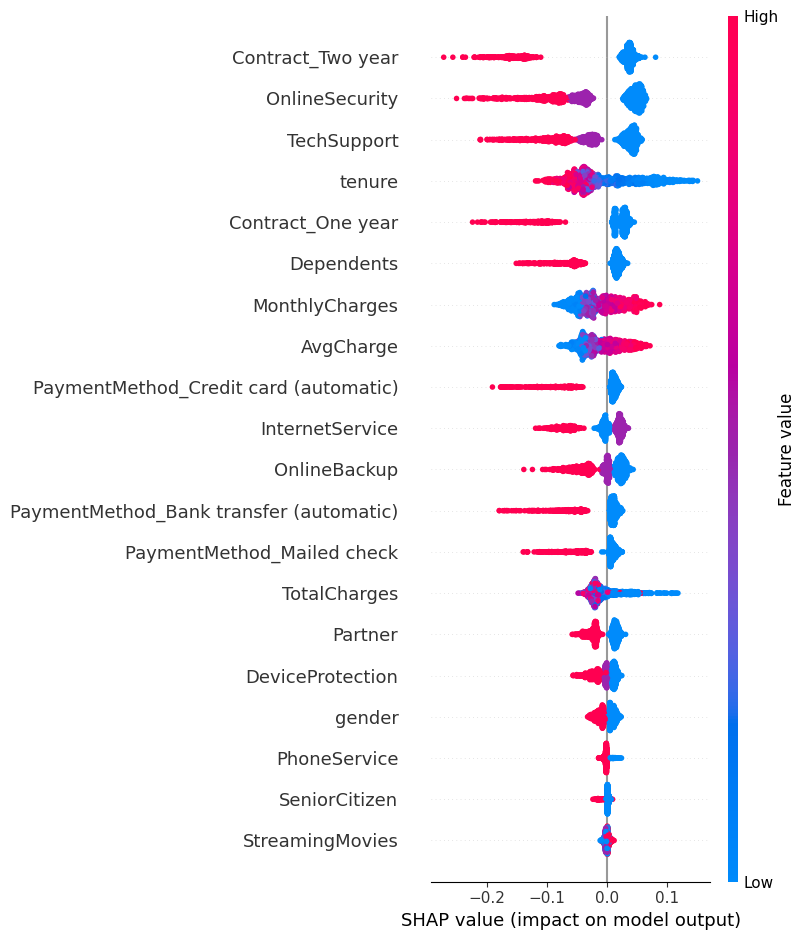

<Figure size 640x480 with 0 Axes>

In [201]:
import shap
import lime
import lime.lime_tabular

# intialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer(X_test)

plt.figure()

# Global feature importance plot
shap.summary_plot(shap_values[:, :, 1], X_test)
plt.savefig('shap_summary_plot.png')
plt.show()

## Key Observations
- "Contract_Two year" (Top Feature)
  - High values (red) are on the left -> Customers with 2-year contracts are less likely to churn.
  - Low values (blue) are on the right -> Customers without 2 year contracts are more likely to churn.
- "OnlineSecurity" & "TechSupport"
  - High values (red) are on the left -> Customers who have these services are less likely to churn.
  - Low values (blue) are on the right -> Customers without these services are more likely to churn.
- "MonthlyCharges"
  - High values (red) on the right -> Higher monthly charges increases churn probabiliy.
  - Low values (blue) on the left -> Lower monthly charges reduces churn probability.
-"Dependents" & "Partner"
  - Having dependents/partner (red) is on the left -> These customers are less likely to churn.
  - No dependents (blue) on the right -> These customers are more likely to churn.

### How to Use This Information
- Target groups at risk of churning (right-side features in red).
  - Offer discounts or better services to customers with high monthly charges.
  - Improve retention strategies for customers who don't have long contracts, security, or tech support.
- Maintain engagement with stable customers (left-side features in red).
  - Customers with long contracts, dependents, and additionl security features are less likely to churn.

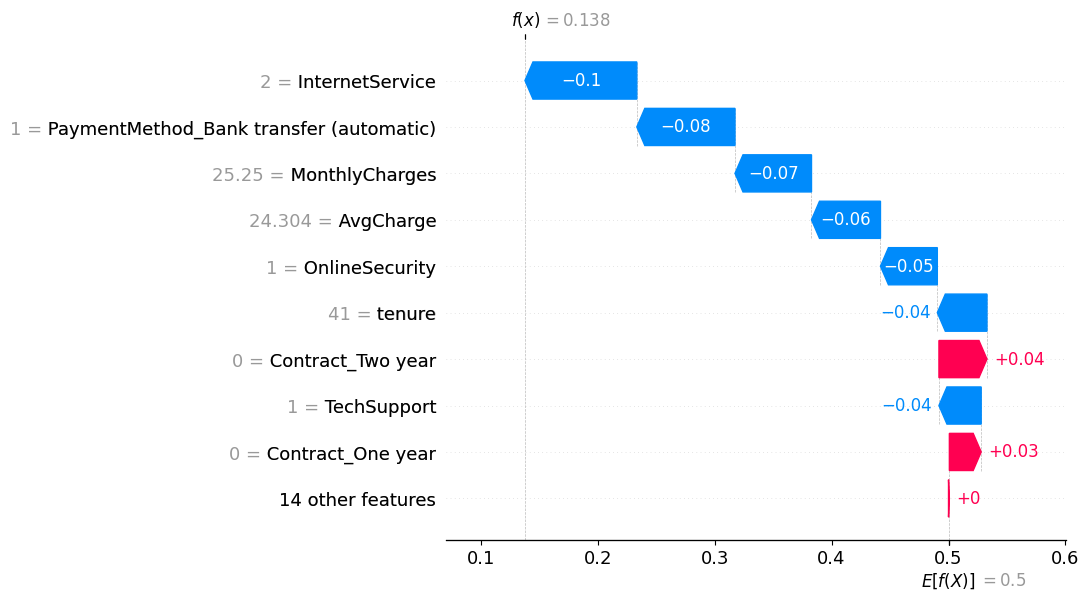

<Figure size 640x480 with 0 Axes>

In [189]:
customer_index = 1
single_shap_values = shap.Explanation(
    values=shap_values.values[customer_index, :, 1],            # SHAP values for class 1 (Churn)
    base_values=shap_values.base_values[customer_index, 1],         # Use the base value for the specific sample and class
    data=X_test.iloc[customer_index]                              # Feature values of the selected instance
)

shap.waterfall_plot(single_shap_values)
plt.savefig('shap_waterfall_plot.png')
plt.show()

Below is a concise explanation of the SHAP waterfall plot:
  1. Baseline(0.50)
    - The model's average predicted probability of churn is 50%.
  2. Negative Bars (Blue)
    - These features decreases the predicted churn probability from 0.50 down to 0.138.
    - For instance, PaymentMethod_Bank transfer (automatic) and InternetService each reduce churn risk significantly, while MonthlyCharges and AvgCharge also push the probability down.
  3. Positive Bars (pink)
    - These features raise the probability slightly.
    - Here, Contract_Two year and Contract_one year nudge the probability upward, though only by a small amount.
  4. Final Prediction (0.138)
    - After considering all features (including **14 other features"), the model concludes this customer has about a 13.8% chance of churning.
In other words, the blue bars show factors making the model more confident the customer will stay, while the pink bars show factors nudging the model toward churn but overall, the net effect is low churn probability.

## Explain Prediction Using LIME
LIME generates local explanations by approximating the model's decision boundary.

In [190]:
# initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_smote.values,
    feature_names=X_train_smote.columns,
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True,
    random_state=42
)

# Explain a single prediction
lime_exp = lime_explainer.explain_instance(X_test.iloc[customer_index].values,
                                           best_rf.predict_proba,
                                           num_features=5)

# Display explanation
lime_exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Test Final Model

In [191]:
# save the trained model as a pickle file
model_data = {'model': best_rf, "feature_names": X.columns.tolist()}


with open("customer_churn_model.pkl", 'wb') as f:
  pickle.dump(model_data, f)

In [192]:
# load the saved model and the encoders

with open('customer_churn_model.pkl', "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data['model']
features_names = model_data['feature_names']

In [193]:
# loaded_model.feature_names_in_

In [194]:
imput_data = df.iloc[customer_index].drop('Churn').to_dict()

input_data_df = pd.DataFrame([imput_data])

with open('categories.pkl', 'rb') as f:
  contract_categories, payment_categories = pickle.load(f)

input_data_eng = feature_engineering_predict(input_data_df, contract_categories, payment_categories)

with open('encoders.pkl', 'rb') as f:
  encoders = pickle.load(f)


# encode categorical features using the saved encoders
for column, encoder in encoders.items():
  input_data_eng[column] = encoder.transform(input_data_eng[column])



# make a prediction
prediction = best_rf.predict(input_data_eng)
pred_prob = best_rf.predict_proba(input_data_eng)


print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediction Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediction Probability: [[0.9377107 0.0622893]]
